# Análise de livros lidos

Sempre gostei muito de ler e, desde mais ou menos 2013, comecei a anotar minhas leituras no aplicativo Goodreads (antes disso, cheguei a criar várias planilhas de controle da minha biblioteca pessoal, mas infelizmente perdi todos os arquivos).

Como exercício de análise dados, decidi olhar para esse histórico para responder uma pergunta-chave: algumas perguntas que, de quebra, podem me ajudar a retomar o hábito de leitura, que já foi mais forte:

- Em que ano li mais, considerando o total de livros lidos?
- Em que ano li mais, considerando o total de _páginas_ lidas?
- Quais foram os anos em que li mais e menos, considerando esses dois critérios acima?
- Nos anos em que li mais, quais foram os gêneros principais?
- Nos anos que li menos, quais foram os gêneros principais?

Respondendo a essas perguntas, espero ter clareza numa pergunta-chave: o que me estimula a ler mais?

Bora lá:

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('goodreads_library_export.csv')
df.head(1)

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
0,22896498,Os segredos de Colin Bridgerton (Os Bridgerton...,Julia Quinn,"Quinn, Julia",Claudia Guimarães,"=""8580413079""","=""9788580413076""",0,3.88,Arqueiro,...,NaN,2025/03/19,"curso-artô, artô","curso-artô (#26), artô (#24)",artô,NaN,NaN,NaN,0,0


Dando uma primeira olhada no dataframe, algumas perguntas adicionais me ocorrem, só por curiosidade:

- Quão diferente é o meu gosto do gosto geral, considerando as colunas "My Rating" e "Average Rating"? Isso muda por gênero?
- Quais são minhas editoras preferidas, considerando média de Rating e total de livros lidos?
- Quanto tempo em média eu demoro entre acrescentar um livro à minha lista e de fato lê-lo?

Mas por enquanto vamos focar nas perguntas originais.

## Olhando e preparando os dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Book Id                     556 non-null    int64  
 1   Title                       556 non-null    object 
 2   Author                      556 non-null    object 
 3   Author l-f                  556 non-null    object 
 4   Additional Authors          231 non-null    object 
 5   ISBN                        556 non-null    object 
 6   ISBN13                      556 non-null    object 
 7   My Rating                   556 non-null    int64  
 8   Average Rating              556 non-null    float64
 9   Publisher                   541 non-null    object 
 10  Binding                     549 non-null    object 
 11  Number of Pages             546 non-null    float64
 12  Year Published              551 non-null    float64
 13  Original Publication Year   519 non

Colunas com valores nulos com as quais teremos que lidar
- Publisher
- Number of Pages
- Year Published

Podemos tentar buscar um database no Kaggle para complementar essas informações.

As outras colunas com valores nuloss ou têm um motivo claro (ex.: "Date Read" nulo indica que ainda não li), ou não serão usadas na análise.

In [4]:
# Tratando os tipos das colunas de data:
df['Date Read'] = pd.to_datetime(df['Date Read'])
df['Date Added'] = pd.to_datetime(df['Date Added'])

In [5]:
df.describe()

,Book Id,My Rating,Average Rating,Number of Pages,Year Published,Original Publication Year,Date Read,Date Added,Read Count,Owned Copies
count,5.560000e+02,556.000000,556.000000,546.000000,551.000000,519.000000,353,556,556.000000,556.000000
mean,1.980152e+07,1.559353,3.967428,281.935897,2007.735027,1967.527938,2014-12-01 08:17:40.623229440,2017-05-08 16:16:24.172662016,0.861511,0.070144
min,1.100000e+01,0.000000,0.000000,0.000000,1900.000000,-400.000000,2003-01-01 00:00:00,2012-12-09 00:00:00,0.000000,0.000000
25%,8.292480e+05,0.000000,3.810000,180.000000,2005.000000,1979.000000,2011-07-01 00:00:00,2013-02-18 00:00:00,1.000000,0.000000
50%,1.140460e+07,0.000000,4.005000,261.000000,2009.000000,2005.000000,2014-08-10 00:00:00,2015-10-12 00:00:00,1.000000,0.000000
75%,2.634046e+07,3.000000,4.162500,351.500000,2015.000000,2012.000000,2018-06-01 00:00:00,2021-01-24 12:00:00,1.000000,0.000000
max,2.109251e+08,5.000000,5.000000,1234.000000,2024.000000,2023.000000,2025-03-13 00:00:00,2025-03-19 00:00:00,4.000000,1.000000
std,2.873709e+07,1.854647,0.397326,154.683262,13.880615,176.576918,NaN,NaN,0.523908,0.255619


In [6]:
df.shape

(556, 24)

São 556 linhas, mas será que existe algum livro duplicado? Vamos verificar pelo ISBN, um identificador único:

In [7]:
df['ISBN13'].value_counts()

ISBN13
=""                 81
="9788580413076"     1
="9780061125270"     1
="9788508070992"     1
="9788503001373"     1
                    ..
="9788551001288"     1
="9788595085930"     1
="9788571647879"     1
="9788537805558"     1
="9781580495806"     1
Name: count, Length: 476, dtype: int64

Existem livros cadastrados no Goodreads sem ISBN, o que eu não sabia que era possível. Vamos verificar quais são eles para ver se há algum erro:

In [8]:
df[df['ISBN13'] == "=\"\"" ]

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
3,197377650,Fool Proof Romance: Love Between the Beat Sheets,Christopher Downing,"Downing, Christopher",NaN,"=""""","=""""",0,4.67,Mad Devil Media,...,NaT,2025-03-19,"curso-artô, artô","curso-artô (#23), artô (#21)",artô,NaN,NaN,NaN,0,0
12,63208986,Pequenas Coisas como Estas,Claire Keegan,"Keegan, Claire",Inês Dias,"=""""","=""""",0,4.14,Relógio D’Água,...,NaT,2025-03-19,"curso-artô, to-read","curso-artô (#14), to-read (#115)",to-read,NaN,NaN,NaN,0,0
38,54844350,Boa Sorte,Helena Cunha,"Cunha, Helena",NaN,"=""""","=""""",0,4.38,NaN,...,2024-05-01,2024-06-16,NaN,NaN,read,NaN,NaN,NaN,1,0
44,60883333,Mandíbula,Mónica Ojeda,"Ojeda, Mónica",Silvia Massimini Felix,"=""""","=""""",0,3.69,Autêntica Contemporânea,...,2024-06-02,2024-04-27,NaN,NaN,read,NaN,NaN,NaN,1,0
45,25190667,Os Vingadores (Os Heróis Mais Poderosos da Mar...,Kurt Busiek,"Busiek, Kurt","George Pérez, Stan Lee, Jack Kirby, Eduardo Sa...","=""""","=""""",0,3.72,Salvat,...,2015-11-15,2015-10-16,NaN,NaN,read,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,5907,"The Hobbit, or There and Back Again",J.R.R. Tolkien,"Tolkien, J.R.R.","Douglas A. Anderson, Michael Hague, Jemima Catlin","=""""","=""""",4,4.29,Houghton Mifflin,...,NaT,2013-02-01,NaN,NaN,read,NaN,NaN,NaN,1,0
532,43035,White Fang,Jack London,"London, Jack",K.A. Applegate,"=""""","=""""",5,4.03,Scholastic Paperbacks,...,NaT,2013-01-30,NaN,NaN,read,NaN,NaN,NaN,4,1
540,12938,King Lear,William Shakespeare,"Shakespeare, William",William James Rolfe,"=""""","=""""",0,3.91,Simon & Schuster,...,2012-01-01,2013-02-01,NaN,NaN,read,NaN,NaN,NaN,1,0
553,1103849,O Homem Duplicado,José Saramago,"Saramago, José",NaN,"=""""","=""""",0,3.97,Editorial Caminho,...,2011-01-01,2013-01-30,NaN,NaN,read,NaN,NaN,NaN,1,0


Realmente temos livros sem ISBN cadastrado, não é um erro. Isso vai complicar um pouco a etapa de remover duplicatas, pois pode ser que livros diferentes tenham o mesmo título. Para verificar, vamos contar os valores únicos na coluna "Title":

In [9]:
df['Title'].nunique()

554

Temos dois casos! Vamos procurar quais são:

In [10]:
df['Title'].value_counts()

Title
Naked Heat (Nikki Heat, #2)                                                       2
Carry On (Simon Snow, #1)                                                         2
Os segredos de Colin Bridgerton (Os Bridgertons, #4)                              1
O Gênio do Crime                                                                  1
Narrative across Media: The Languages of Storytelling (Frontiers of Narrative)    1
                                                                                 ..
Crisálida                                                                         1
Teocrasília, Livro 1: O Fim da Inocência                                          1
Mitologia Nórdica                                                                 1
Por que não pediram a Evans?                                                      1
The Importance of Being Earnest                                                   1
Name: count, Length: 554, dtype: int64

Achamos dois casos. Meu palpite, sabendo os títulos, é que cadastrei uma versão em inglês e uma versão em português. Vamos verificar:

In [11]:
df[(df['Title'] == 'Carry On (Simon Snow, #1)') | (df['Title'] == 'Naked Heat (Nikki Heat, #2)')]

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
246,9536649,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""078689136X""","=""9780786891368""",3,3.79,Hyperion,...,2019-08-26,2019-08-09,NaN,NaN,read,NaN,NaN,NaN,1,0
289,32768522,"Carry On (Simon Snow, #1)",Rainbow Rowell,"Rowell, Rainbow",NaN,"=""1250135028""","=""9781250135025""",4,4.16,Wednesday Books,...,NaT,2017-07-14,NaN,NaN,read,NaN,NaN,NaN,1,0
293,34705485,"Carry On (Simon Snow, #1)",Rainbow Rowell,"Rowell, Rainbow",NaN,"=""8542809483""","=""9788542809480""",4,4.16,Novo Século,...,2017-07-14,2014-12-10,NaN,NaN,read,NaN,NaN,NaN,1,0
445,7776678,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""1401324029""","=""9781401324025""",3,3.79,Hyperion,...,2011-01-01,2013-01-03,NaN,NaN,read,NaN,NaN,NaN,2,0


Meu palpite se confirmou no caso de "Carry On" (pude verificar pelo nome da editora, uma brasileira e uma dos EUA), mas não no caso de "Naked Heat".

Procurando pelos dois ISBNs de Naked Heat no Google, entendi o que aconteceu: um ISBN se refere à edição de capa dura e o outro, à edição paperback. Como sei que só li o paperback, provavelmente reli o livro e acidentalmente registrei na edição errada.

Por isso, farei os seguintes tratamentos:

- Para "Carry On", vou excluir a entrada de índice 289, porque me lembro de só ter lido em português, o que é reforçado pela falta de valor na coluna "Date Read" da versão em inglês. Em relação à divergência de valores na coluna Date Added, vou manter a mais antiga.

- Para "Naked Heat", vou manter apenas entrada de índice 246 (paperback) e somar o total de releituras das duas entradas. Comparando o site original do Goodreads e o arquivo csv que ele me entrega, verifiquei que, para livros que foram lidos mais de uma vez, ele registra apenas a primeira data de leitura.[1] Então, vou seguir esse padrão ao tratar os dados.

[1] Isso traz outra implicação ao fazer as análises para responder às perguntas: anos em que eu reli muitos livros terão sua contagem de leitura reduzida nessa análise.

In [12]:
# Removendo a linha 289 do dataframe:
df = df.drop([289])

# Testando se deu certo:

df[df['Title'] == 'Carry On (Simon Snow, #1)']

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
293,34705485,"Carry On (Simon Snow, #1)",Rainbow Rowell,"Rowell, Rainbow",NaN,"=""8542809483""","=""9788542809480""",4,4.16,Novo Século,...,2017-07-14,2014-12-10,NaN,NaN,read,NaN,NaN,NaN,1,0


In [13]:
# Obtendo o Read Count total do livro duplicado e armazenando numa variável:
read_count_naked_heat = df[df['Title'] == 'Naked Heat (Nikki Heat, #2)']['Read Count'].sum()

# Alterando o valor da coluna:
df.loc[[246], ['Read Count']] = read_count_naked_heat

# Verificando se deu certo:
df[df['Title'] == 'Naked Heat (Nikki Heat, #2)']

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
246,9536649,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""078689136X""","=""9780786891368""",3,3.79,Hyperion,...,2019-08-26,2019-08-09,NaN,NaN,read,NaN,NaN,NaN,3,0
445,7776678,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""1401324029""","=""9781401324025""",3,3.79,Hyperion,...,2011-01-01,2013-01-03,NaN,NaN,read,NaN,NaN,NaN,2,0


In [14]:
# Colocando os valores mínimos das colunas "Date Read" e "Date Added" na linha que vamos manter:

df.loc[[246], ['Date Read']] = df[df['Title'] == 'Naked Heat (Nikki Heat, #2)']['Date Read'].min()
df.loc[[246], ['Date Added']] = df[df['Title'] == 'Naked Heat (Nikki Heat, #2)']['Date Added'].min()

# Verificando se deu certo:

df[df['Title'] == 'Naked Heat (Nikki Heat, #2)']

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
246,9536649,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""078689136X""","=""9780786891368""",3,3.79,Hyperion,...,2011-01-01,2013-01-03,NaN,NaN,read,NaN,NaN,NaN,3,0
445,7776678,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""1401324029""","=""9781401324025""",3,3.79,Hyperion,...,2011-01-01,2013-01-03,NaN,NaN,read,NaN,NaN,NaN,2,0


In [15]:
# Removendo a linha que não vamos usar do df:
df = df.drop([445])

# Novamente, verificando se deu certo:

df[df['Title'] == 'Naked Heat (Nikki Heat, #2)']

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
246,9536649,"Naked Heat (Nikki Heat, #2)",Richard Castle,"Castle, Richard",NaN,"=""078689136X""","=""9780786891368""",3,3.79,Hyperion,...,2011-01-01,2013-01-03,NaN,NaN,read,NaN,NaN,NaN,3,0


Uma observação sobre o resultado final dessa linha: o campo Date Added é posterior ao campo Date Read. Isso não é um erro, apenas indica que quando eu cadastrei o livro eu já o havia lido e coloquei a data de leitura retroativamente.

In [19]:
# Verificando se agora todos os títulos de livros são valores únicos:
df['Title'].value_counts()

Title
Os segredos de Colin Bridgerton (Os Bridgertons, #4)                                         1
O Menino Que Adivinhava                                                                      1
Soul Love: À Noite o Céu é Perfeito!                                                         1
O Hobbit e A Filosofia: Para quando você tiver perdido seus anões, seu mago e seu caminho    1
Narrative across Media: The Languages of Storytelling (Frontiers of Narrative)               1
                                                                                            ..
Crisálida                                                                                    1
Teocrasília, Livro 1: O Fim da Inocência                                                     1
Mitologia Nórdica                                                                            1
Por que não pediram a Evans?                                                                 1
The Importance of Being Earnest             

Agora, como as perguntas que levantei são todas relacionadas a anos, vou criar uma coluna de "ano lido". Por curiosidade, vou criar também uma de "ano adicionado":

In [86]:
df['Year_Read'] = df['Date Read'].dt.year.astype('Int64')
df['Year_Added'] = df['Date Added'].dt.year.astype('Int64')

# Para verificar se criou certo:

df[['Date Read','Year_Read','Date Added','Year_Added']]

,Date Read,Year_Read,Date Added,Year_Added
0,NaT,<NA>,2025-03-19,2025
1,NaT,<NA>,2025-03-19,2025
2,NaT,<NA>,2025-03-19,2025
3,NaT,<NA>,2025-03-19,2025
4,NaT,<NA>,2025-03-19,2025
...,...,...,...,...
551,2011-08-01,2011,2013-01-30,2013
552,2011-01-01,2011,2013-01-30,2013
553,2011-01-01,2011,2013-01-30,2013
554,2011-02-01,2011,2013-01-30,2013


## Retomando as perguntas:

### Em que ano mais li

In [174]:
# Criando uma tabela com o total de livros e páginas lidos por ano:

leitura_ano = df.groupby(['Year_Read'], as_index=False).aggregate({'Book Id':'count','Number of Pages':'sum'})
leitura_ano['Year_Read'] = leitura_ano['Year_Read'].astype('Int64')

# Excluindo da tabela o ano de 2025, que não está completo:
leitura_ano = leitura_ano[leitura_ano['Year_Read'] < 2025]

# Printando para verificar:
leitura_ano

,Year_Read,Book Id,Number of Pages
0,2003,10,1528.0
1,2004,5,1171.0
2,2005,3,733.0
3,2006,2,402.0
4,2007,17,4127.0
5,2008,9,2273.0
6,2009,8,2012.0
7,2010,7,1949.0
8,2011,39,12853.0
9,2012,19,6356.0


In [175]:
# Por curiosidade, vou criar também uma coluna "Ritmo", baseada no Pace das corridas (quantos dias por livro), e uma média de páginas por livro)

leitura_ano['Pace_Books'] = 365 / leitura_ano['Book Id']
leitura_ano['Pace_Books'] = leitura_ano['Pace_Books'].round(decimals=2)
leitura_ano['Page_Average'] = leitura_ano['Number of Pages']/leitura_ano['Book Id']
leitura_ano['Page_Average'] = leitura_ano['Page_Average'].round(decimals=2)
leitura_ano

,Year_Read,Book Id,Number of Pages,Pace_Books,Page_Average
0,2003,10,1528.0,36.50,152.80
1,2004,5,1171.0,73.00,234.20
2,2005,3,733.0,121.67,244.33
3,2006,2,402.0,182.50,201.00
4,2007,17,4127.0,21.47,242.76
5,2008,9,2273.0,40.56,252.56
6,2009,8,2012.0,45.62,251.50
7,2010,7,1949.0,52.14,278.43
8,2011,39,12853.0,9.36,329.56
9,2012,19,6356.0,19.21,334.53


In [176]:
leitura_ano.describe()

,Year_Read,Book Id,Number of Pages,Pace_Books,Page_Average
count,22.0,22.000000,22.000000,22.000000,22.000000
mean,2013.5,15.863636,4340.045455,39.891364,261.102273
std,6.493587,10.615781,3343.040511,40.473001,51.270064
min,2003.0,2.000000,402.000000,8.900000,152.800000
25%,2008.25,9.250000,2048.000000,17.837500,236.340000
50%,2013.5,11.500000,3864.500000,31.800000,253.115000
75%,2018.75,20.500000,5416.250000,39.545000,285.480000
max,2024.0,41.000000,12853.000000,182.500000,358.360000


In [177]:
mais_livros = leitura_ano['Book Id'].max()
ano_mais_livros = leitura_ano.loc[leitura_ano['Book Id'].idxmax(),'Year_Read']
mais_livros_media = leitura_ano.loc[leitura_ano['Book Id'].idxmax(),'Page_Average']
mais_pgs = leitura_ano['Number of Pages'].max()
ano_mais_pgs = leitura_ano.loc[leitura_ano['Number of Pages'].idxmax(),'Year_Read']
mais_pgs_media = leitura_ano.loc[leitura_ano['Number of Pages'].idxmax(),'Page_Average']

Respondendo então às primeiras duas perguntas:

In [178]:
print(f'Considerando total de LIVROS, o ano em que mais li foi {ano_mais_livros}, com um total de {mais_livros} livros e média de {mais_livros_media} pgs/livro.')
print(f'Considerando total de PÁGINAS, o ano em que mais li foi {ano_mais_pgs}, com um total de {mais_pgs} páginas e média de {mais_pgs_media} pgs/livro.')

Considerando total de LIVROS, o ano em que mais li foi 2014, com um total de 41 livros e média de 288.54 pgs/livro.
Considerando total de PÁGINAS, o ano em que mais li foi 2011, com um total de 12853.0 páginas e média de 329.56 pgs/livro.


Para ficar visual, vamos fazer um gráfico:

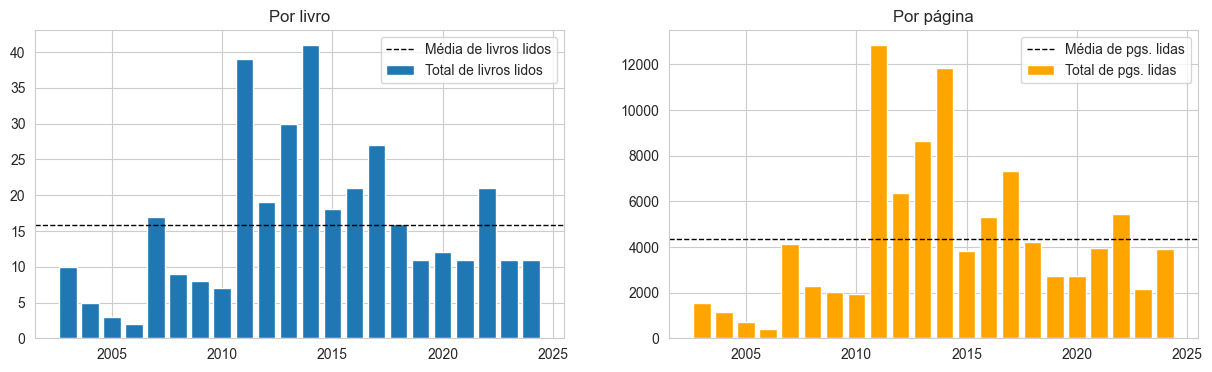

In [190]:
# Aplicando estilos do seaborn para ficar mais bonito:
sns.set_style('whitegrid')

# Construindo os gráficos
fig, axes = plt.subplots(1,2, figsize=(15,4))

# Por livro:
axes[0].bar(leitura_ano['Year_Read'],
            leitura_ano['Book Id'],
            label = 'Total de livros lidos')
axes[0].set_title('Por livro')
# Incluindo linha de média:
axes[0].axhline(
    y = leitura_ano['Book Id'].mean(),
    color = 'k',
    linestyle = '--',
    linewidth = 1,
    label = 'Média de livros lidos'
)
axes[0].legend()

# Por página
axes[1].bar(leitura_ano['Year_Read'],
            leitura_ano['Number of Pages'],
            color='orange',
            label = 'Total de pgs. lidas')
axes[1].set_title('Por página')
axes[1].axhline(
    y = leitura_ano['Number of Pages'].mean(),
    color = 'k',
    linestyle = '--',
    linewidth = 1,
    label = 'Média de pgs. lidas'
)
axes[1].legend()

Podemos tirar algumas observações do gráfico:

- Existe uma concentração de anos em que li acima da média de 2011 a 2017, principalmente até 2014. Esses períodos coincidem com o período em que eu estava na graduação (2011 a 2015/1) e, posteriormente, parte do mestrado (2016 a 2018/1).
  - Nesse período, o único ano que a o número de páginas ficou abaixo da média foi 2015. É interessante ver se o padrão de leitura foi diferente nesse ano.
- Em 2022, houve um pico de leituras acima da média novamente. Também foi o ano em que eu tive um acidente que me deixou com mobilidade reduzida. Será que isso me estimulou a ler mais, já que não podia fazer outras atividades? Posso averiguar isso pelo mês.

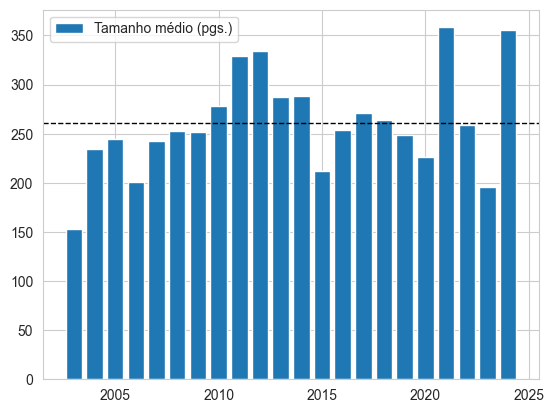

In [196]:
# Verificando visualmente se o tamanho médio dos livros foi menor em 2015:

plt.bar(leitura_ano['Year_Read'],leitura_ano['Page_Average'], label ='Tamanho médio (pgs.)')
plt.legend()
plt.axhline(
    y = leitura_ano['Page_Average'].mean(),
    color = 'k',
    linestyle = '--',
    linewidth = 1,
    label = 'Média de livros lidos'
)

In [210]:
# Verificando os livros lidos em 2015 por tamanho:
df[df['Year_Read'] == 2024][['Title','Date Read','Number of Pages','ISBN13']]

,Title,Date Read,Number of Pages,ISBN13
34,"Um Barril de Risadas, Um Vale de Lágrimas",2024-12-31,192.0,"=""9788571646148"""
36,Sem tempo a perder: Reflexões sobre o que real...,2024-10-16,240.0,"=""9788576575641"""
37,POR UMA ÉTICA QUEER,2024-09-25,0.0,"=""9786581097738"""
38,Boa Sorte,2024-05-01,260.0,"="""""
44,Mandíbula,2024-06-02,304.0,"="""""
49,O andar do bêbado,2024-04-21,264.0,"=""9788537807675"""
52,Crônica da Casa Assassinada,2024-01-20,810.0,"=""9788400071271"""
53,A Casa dos Espíritos,2024-03-11,448.0,"=""9788528622560"""
58,"Legado (Silo, #3)",2024-02-17,368.0,"=""9788580579413"""
59,"Ordem (Silo, #2)",2024-02-14,512.0,"=""9788580576818"""


In [211]:
# Verificando a distribuição de livros por mês em 2022:
df[df['Year_Read'] == 2024][['Title','Date Read','Number of Pages']].sort_values(by=['Date Read'])

,Title,Date Read,Number of Pages
52,Crônica da Casa Assassinada,2024-01-20,810.0
60,Silo (Silo #1),2024-02-04,512.0
59,"Ordem (Silo, #2)",2024-02-14,512.0
58,"Legado (Silo, #3)",2024-02-17,368.0
53,A Casa dos Espíritos,2024-03-11,448.0
49,O andar do bêbado,2024-04-21,264.0
38,Boa Sorte,2024-05-01,260.0
44,Mandíbula,2024-06-02,304.0
37,POR UMA ÉTICA QUEER,2024-09-25,0.0
36,Sem tempo a perder: Reflexões sobre o que real...,2024-10-16,240.0
